# **미니프로젝트 4차 1대1 문의 내용 유형 분류기**
# 단계3 : Text classification

### 문제 정의
> 1:1 문의 내용 분류 문제<br>
> 1. 문의 내용 분석
> 2. 문의 내용 분류 모델 성능 평가
### 학습 데이터
> * 1:1 문의 내용 데이터 : train.csv

### 변수 소개
> * text : 문의 내용
> * label : 문의 유형

### References
> * Machine Learning
>> * [sklearn-tutorial](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)
> * Deep Learning
>> * [Google Tutorial](https://developers.google.com/machine-learning/guides/text-classification)
>> * [Tensorflow Tutorial](https://www.tensorflow.org/tutorials/keras/text_classification)
>> * [Keras-tutorial](https://keras.io/examples/nlp/text_classification_from_scratch/)
>> * [BERT-tutorial](https://www.tensorflow.org/text/guide/bert_preprocessing_guide)

## 1. 개발 환경 설정

### 1-1. 라이브러리 설치

In [1]:
# 필요 라이브러리부터 설치할께요.
# !pip install konlpy pandas seaborn wordcloud python-mecab-ko wget transformers

### 1-2. 라이브러리 import

In [2]:
from mecab import MeCab
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wget,os
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import tensorflow as tf
import nltk
import wget,os

In [3]:
# 런타임 재시작 필요
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf

### 1-3. 한글 글꼴 설정

In [4]:
# !sudo apt-get install -y fonts-nanum

In [5]:
FONT_PATH = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=FONT_PATH, size=10).get_name()
print(font_name)
plt.rcParams['font.family']=font_name
assert plt.rcParams['font.family'] == [font_name], "한글 폰트가 설정되지 않았습니다."

NanumGothic


### 1-4. 구글드라이브 연결

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. 전처리한 데이터 불러오기
* 1, 2일차에 전처리한 데이터를 불러옵니다.
* sparse data에 대해서는 scipy.sparse.load_npz 활용

In [7]:
import os
import numpy as np
import scipy.sparse

home_directory = os.path.expanduser('/content/drive/MyDrive/에이블/미니프로젝트4차_3~7일차/')
p = os.path.join(home_directory, '')

x_tr_tfidf = scipy.sparse.load_npz(p+'X_tfidf_train.npz')

x_val_tfidf = scipy.sparse.load_npz(p+'X_tfidf_val.npz')

x_te_tfidf = scipy.sparse.load_npz(p+'X_tfidf_te.npz')

X_mor_tr_seq = np.load(p+'X_mor_sequence_train.npy')

X_mor_val_seq = np.load(p+'X_mor_sequence_val.npy')

X_mor_te_seq = np.load(p+'X_mor_sequence_te.npy')

Y_tr = np.load(p+'y_train.npy')

Y_val = np.load(p+'y_val.npy')

## 3. Machine Learning(N-grams)
* N-gram으로 전처리한 데이터를 이용하여 3개 이상의 Machine Learning 모델 학습 및 성능 분석
> * [sklearn-tutorial](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

### 3-1. Model 1

In [8]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# 머신러닝 모델을 학습합니다.
clf = MultinomialNB()
clf.fit(x_tr_tfidf, Y_tr)

# 학습된 모델을 사용하여 예측합니다.
pred_labels = clf.predict(x_val_tfidf)

# 모델의 성능을 평가합니다.
accuracy = accuracy_score(Y_val, pred_labels)
print("Accuracy: {:.2f}%".format(accuracy * 100))


Accuracy: 64.75%


### 3-2. Model 2

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression()
clf.fit(x_tr_tfidf, Y_tr)

# 학습된 모델을 사용하여 예측합니다.
pred_labels = clf.predict(x_val_tfidf)

# 모델의 성능을 평가합니다.
accuracy = accuracy_score(Y_val, pred_labels)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 83.99%


### 3-3. Model 3

In [10]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

clf = SVC(kernel="linear")
clf.fit(x_tr_tfidf, Y_tr)

pred_labels = clf.predict(x_val_tfidf)

accuracy = accuracy_score(Y_val, pred_labels)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 84.17%


### 3-4. Hyperparameter Tuning(Optional)
* Manual Search, Grid search, Bayesian Optimization, TPE...
> * [grid search tutorial sklearn](https://scikit-learn.org/stable/modules/grid_search.html)
> * [optuna tutorial](https://optuna.org/#code_examples)
> * [ray-tune tutorial](https://docs.ray.io/en/latest/tune/examples/tune-sklearn.html)

## 4. Deep Learning(Sequence)
* Sequence로 전처리한 데이터를 이용하여 DNN, 1-D CNN, LSTM 등 3가지 이상의 deep learning 모델 학습 및 성능 분석
> * [Google Tutorial](https://developers.google.com/machine-learning/guides/text-classification)
> * [Tensorflow Tutorial](https://www.tensorflow.org/tutorials/keras/text_classification)
> * [Keras-tutorial](https://keras.io/examples/nlp/text_classification_from_scratch/)

### 4-1. DNN

In [11]:
import keras
from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

TOP_K = 5000
MAX_SEQUENCE_LENGTH = 500

#체크 포인트 설정 1 : 학습 진행 중 모델을 저장하기 위한 설정
modelpath = '/content/drive/MyDrive/에이블/미니프로젝트4차_3~7일차/path_to_save_model.h5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=False)

#학습 중단 조건 설정 : monitor 지표가 더 나아 지지 않으면 학습을 중단함.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

# seed 값 설정 (일정한 값이 나오도록 함.)
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

dnn_model = Sequential()
dnn_model.add(Embedding(TOP_K + 1, 128, input_length=MAX_SEQUENCE_LENGTH))
dnn_model.add(Dense(128, activation='relu'))
dnn_model.add(Flatten())
dnn_model.add(Dense(5, activation='softmax'))
dnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          640128    
                                                                 
 dense (Dense)               (None, 500, 128)          16512     
                                                                 
 flatten (Flatten)           (None, 64000)             0         
                                                                 
 dense_1 (Dense)             (None, 5)                 320005    
                                                                 
Total params: 976645 (3.73 MB)
Trainable params: 976645 (3.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_mor_tr_seq, Y_tr, test_size=0.2, random_state=42)

history = dnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, callbacks=[checkpointer, early_stopping_callback])

Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 1.2600 - accuracy: 0.4559
Epoch 1: saving model to /content/drive/MyDrive/에이블/미니프로젝트4차_3~7일차/path_to_save_model.h5
67/67 [==============================] - 13s 161ms/step - loss: 1.2600 - accuracy: 0.4559 - val_loss: 1.1804 - val_accuracy: 0.5000
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - ETA: 0s - loss: 0.9575 - accuracy: 0.6418
Epoch 2: saving model to /content/drive/MyDrive/에이블/미니프로젝트4차_3~7일차/path_to_save_model.h5
67/67 [==============================] - 9s 130ms/step - loss: 0.9575 - accuracy: 0.6418 - val_loss: 1.0466 - val_accuracy: 0.5821
Epoch 3/10
67/67 [==============================] - ETA: 0s - loss: 0.5118 - accuracy: 0.8575
Epoch 3: saving model to /content/drive/MyDrive/에이블/미니프로젝트4차_3~7일차/path_to_save_model.h5
67/67 [==============================] - 4s 62ms/step - loss: 0.5118 - accuracy: 0.8575 - val_loss: 0.9041 - val_accuracy: 0.7034
Epoch 4/10
67/67 [==============================] - ETA: 0s - loss: 0.2056 - accuracy: 0.9468
Epoch 4: saving model to /content/drive/MyDrive/에이블/미니프로젝트4차_3~7일차/path_to_save_model.h5
67/67 [==============================] - 7s 102ms/step - loss: 0.2056 - accuracy: 0.9468 - val_loss: 0.8829 - val_accuracy: 0.7481
Epoch 5/10
67/67 [=======

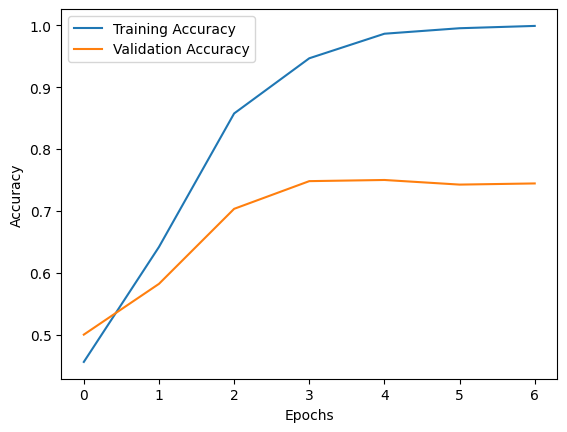

In [13]:
# 학습 곡선 그래프
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 4-2. 1-D CNN

In [14]:
import os
import keras
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

TOP_K = 5000
MAX_SEQUENCE_LENGTH = 500

# 모델을 저장할 디렉토리 생성
MODEL_DIR = "/content/drive/MyDrive/에이블/미니프로젝트4차_3~7일차/CNN_model/"
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

# 저장할 모델 이름 설정
modelpath = MODEL_DIR + "/extended_cnn_fepoch:{epoch:02d}-val_loss:{val_loss:.4f}-val_accuracy:{val_accuracy:.4f}.hdf5"

# 체크 포인트 설정: 학습 진행 중 모델을 저장하기 위한 설정
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)

# CNN 모델 설계
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=TOP_K + 1, output_dim=8, input_length=MAX_SEQUENCE_LENGTH))
cnn_model.add(Conv1D(64, 5, padding='valid', activation='relu', strides=1))
cnn_model.add(MaxPooling1D(pool_size=4))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(5, activation='softmax'))

# 모델 컴파일
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 8)            40008     
                                                                 
 conv1d (Conv1D)             (None, 496, 64)           2624      
                                                                 
 max_pooling1d (MaxPooling1  (None, 124, 64)           0         
 D)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 7936)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1015936   
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                      

In [15]:
from keras.preprocessing.sequence import pad_sequences

# 시퀀스 데이터를 패딩하여 일정한 길이로
X_mor_tr_seq_padded = pad_sequences(X_mor_tr_seq, maxlen=MAX_SEQUENCE_LENGTH)

X_train, X_val, y_train, y_val = train_test_split(X_mor_tr_seq_padded, Y_tr, test_size=0.2, random_state=42)

cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = cnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, callbacks=[checkpointer, early_stopping_callback])

Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 1.3241 - accuracy: 0.4274
Epoch 1: val_loss improved from inf to 1.25214, saving model to /content/drive/MyDrive/에이블/미니프로젝트4차_3~7일차/CNN_model/extended_cnn_fepoch:01-val_loss:1.2521-val_accuracy:0.4179.hdf5
67/67 [==============================] - 5s 45ms/step - loss: 1.3241 - accuracy: 0.4274 - val_loss: 1.2521 - val_accuracy: 0.4179
Epoch 2/10
 3/67 [>.............................] - ETA: 1s - loss: 1.2121 - accuracy: 0.4479

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - ETA: 0s - loss: 1.1445 - accuracy: 0.4946
Epoch 2: val_loss improved from 1.25214 to 1.13979, saving model to /content/drive/MyDrive/에이블/미니프로젝트4차_3~7일차/CNN_model/extended_cnn_fepoch:02-val_loss:1.1398-val_accuracy:0.5243.hdf5
67/67 [==============================] - 2s 34ms/step - loss: 1.1445 - accuracy: 0.4946 - val_loss: 1.1398 - val_accuracy: 0.5243
Epoch 3/10
67/67 [==============================] - ETA: 0s - loss: 0.9380 - accuracy: 0.6366
Epoch 3: val_loss improved from 1.13979 to 1.02379, saving model to /content/drive/MyDrive/에이블/미니프로젝트4차_3~7일차/CNN_model/extended_cnn_fepoch:03-val_loss:1.0238-val_accuracy:0.5989.hdf5
67/67 [==============================] - 2s 34ms/step - loss: 0.9380 - accuracy: 0.6366 - val_loss: 1.0238 - val_accuracy: 0.5989
Epoch 4/10
66/67 [============================>.] - ETA: 0s - loss: 0.6503 - accuracy: 0.7959
Epoch 4: val_loss improved from 1.02379 to 0.88769, saving model to /co

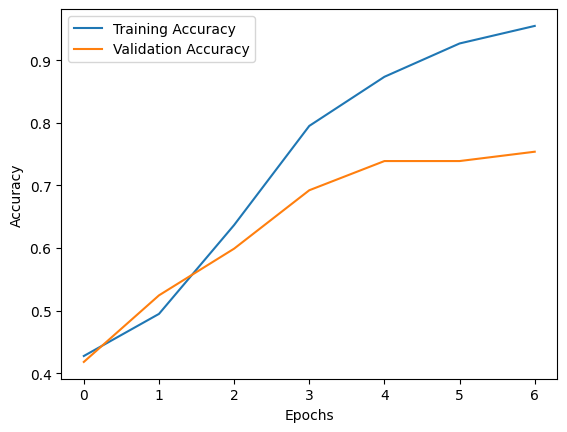

In [16]:
# 학습 곡선 그래프
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 4-3. LSTM

## 5. Using pre-trained model(Optional)
* 한국어 pre-trained model로 fine tuning 및 성능 분석
> * [BERT-tutorial](https://www.tensorflow.org/text/guide/bert_preprocessing_guide)
> * [HuggingFace-Korean](https://huggingface.co/models?language=korean)